In [ ]:
import os
import random
import sys
from contextlib import contextmanager
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from casadi import dot, vertcat, vertsplit
from do_mpc.controller import MPC
from do_mpc.model import Model
from do_mpc.simulator import Simulator
from tqdm import tqdm

from core.generator import (
    gen_step,
)
from core.greenhouse_model import A_p as greenhouse_area
from core.greenhouse_model import _model as _gh_model
from core.greenhouse_model import heater, ventilation
from core.greenhouse_model import model as gh_model
from core.openmeteo_query import get_weather_data
from core.plot import plot_response, plot_states, set_size
from core.simulate import simulate
from examples.GES_Example import z


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


# For reproducibility
random.seed(40)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Get Weather Data

In [ ]:
start_date = pd.Timestamp.now() - pd.Timedelta(days=16)
climdat = get_weather_data(
    latitude=52.52,  # Latitude of the location in degrees
    longitude=13.41,  # Longitude of the location in degrees
    tilt=[
        90,
        40,
        90,
        40,
        90,
        40,
        90,
        40,
    ],  # Tilt angle of the surface in degrees
    azimuth=[
        "NE",
        "NE",
        "SE",
        "SE",
        "SW",
        "SW",
        "NW",
        "NW",
    ],  # Azimuth angle of the surface in degrees (South facing)
    frequency="minutely_15",
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=pd.Timestamp.now().strftime("%Y-%m-%d"),
)

climate = climdat.asfreq("1s").interpolate(method="time")
start_date = pd.Timestamp(climate.index[0])

In [ ]:
# Plotting the DataFrame
ax = climdat.plot()

# Placing the legend above the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=3)

# Displaying the plot
plt.show()

## Explore responses to steps in individual inputs

In [ ]:
ts = 60

x0 = z

u_min = [0.0, 0.0]
u_max = [100.0, 100.0]

In [ ]:
y_label = [r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
u_label = [
    r"$u_{\mathrm{R_{a,max}}}$",
    r"$u_{\mathrm{Q_{heat}}}$",
]

In [ ]:
greenhouse_model = partial(gh_model, climate=climate.values)

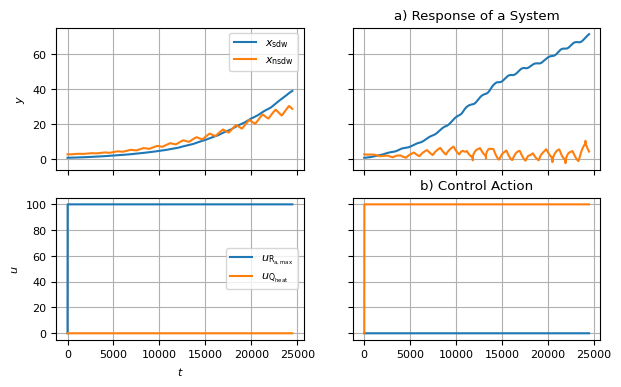

In [ ]:
# [donotremove]
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=int(len(climate) / ts),
        t_s=ts,
        x0=x0,  # type: ignore
    )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 0].legend()

plt.show()

### Plot all the hidden states

In [ ]:
_greenhouse_model = partial(_gh_model, climate=climate.values)

100%|██████████| 24464/24464 [00:22<00:00, 1070.24it/s]


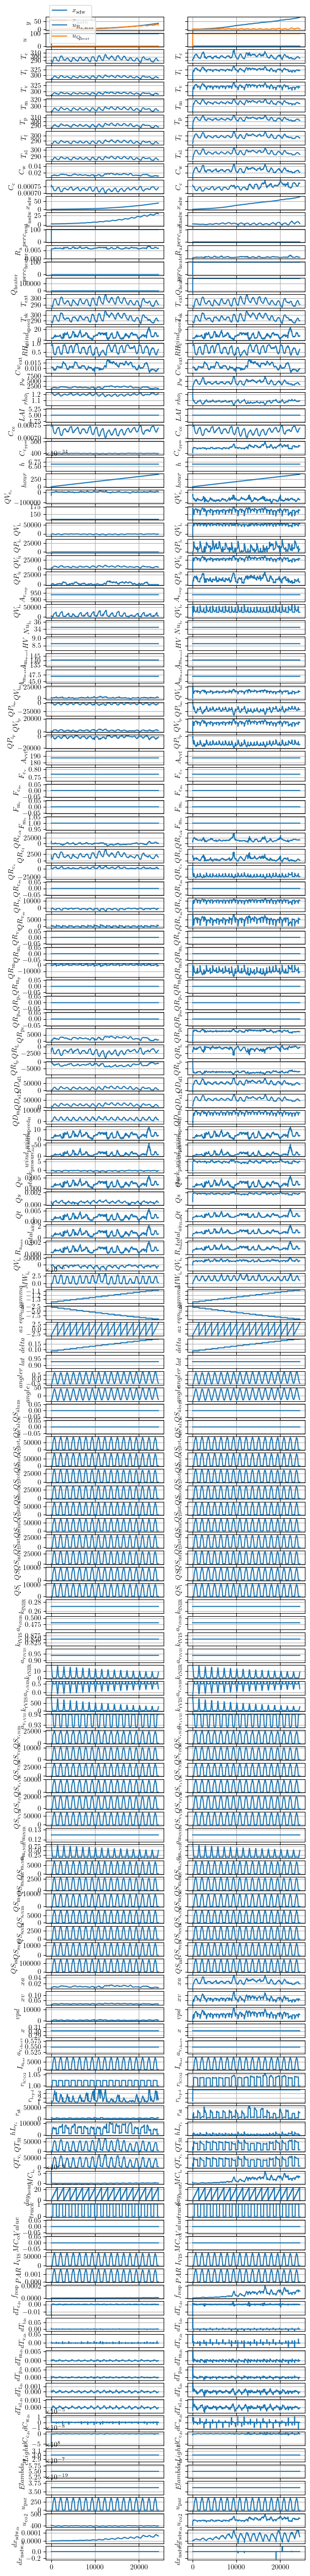

In [ ]:
# [donotremove]
for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=int(len(climate) / ts),
        t_s=ts,
        x0=x0,  # type: ignore
    )

    xs = []
    for i, (x, u) in enumerate(zip(y_out, u_out)):
        _, x_ = _greenhouse_model(i * ts, tuple(x), tuple(u))
        xs.append(x_)
    df = pd.DataFrame(xs, index=t_out).select_dtypes(include=["float"])

    if u_idx == 0:
        # Plot response
        fig, axs = plt.subplots(
            nrows=2 + len(df.columns),
            ncols=len(u_max),
            figsize=(6, round(len(df.columns) / 2)),
            sharex=True,
            sharey="row",
        )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )
    # Plot states
    plot_states(df, axs[2:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 0].legend()

plt.show()

In [ ]:
# === Model ===================================================================
# Create a model instance
model = Model("discrete")

dt = 60  # [s]
# Define optimization variables
n_states = len(z)
n_controls = 2
# Define state and control variables
t = model.set_variable(var_type="_tvp", var_name="t", shape=(1, 1))
x = model.set_variable(var_type="_x", var_name="x", shape=(n_states, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(n_controls, 1))
tvp = {
    name: model.set_variable(var_type="_tvp", var_name=name)
    for name in climate.columns
}


# Define the model equations
def f(t, x, u, tvp):
    return vertcat(
        *gh_model(t, vertsplit(x), vertsplit(u), climate=tuple(tvp.values()))
    )


k1 = f(t, x[:, 0], u[:, 0], tvp)
k2 = f(t, x[:, 0] + dt / 2 * k1, u[:, 0], tvp)
k3 = f(t, x[:, 0] + dt / 2 * k2, u[:, 0], tvp)
k4 = f(t, x[:, 0] + dt * k3, u[:, 0], tvp)
x_next = x[:, 0] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

model.set_rhs("x", x_next)

model.setup()

# === Simulator ===============================================================
# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": dt}

simulator.set_param(**params_simulator)

# Get the template
tvp_sim_template = simulator.get_tvp_template()


# Define the function (indexing is much simpler ...)
def tvp_sim_fun(t_now):
    if isinstance(t_now, np.ndarray):
        t_now = t_now[0]
    tvp_sim_template["t"] = t_now
    for key in climate.columns:
        tvp_sim_template[key] = climate[key][
            start_date + pd.Timedelta(seconds=t_now)
        ]
    return tvp_sim_template


# Set the tvp_fun:
simulator.set_tvp_fun(tvp_sim_fun)

simulator.setup()

# === Runtime =================================================================
sim_steps = int(len(climate) / 60)
# Find feasible initial state
x0 = z
u0 = np.array([100.0, 100.0], ndmin=2).T

simulator.x0 = x0

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
ums = []
uos = []
for ss_ in tqdm(range(sim_steps)):
    ums.append([u_min, u_max])
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next[-2:])
    x0 = y_next
    if np.isnan(x0).any():
        raise ValueError("x0 contains NaN values.")
    x0s.append(x0)

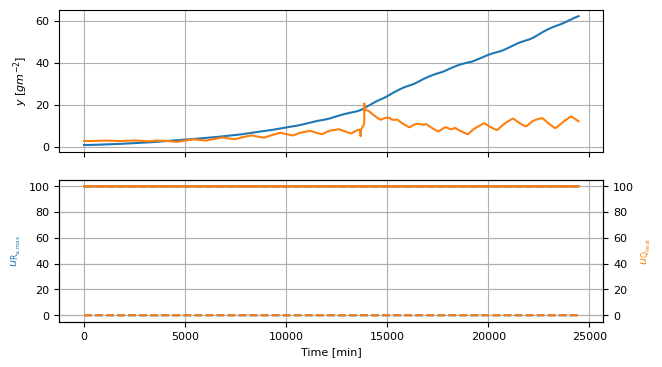

In [ ]:
# [donotremove]
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(range(sim_steps), np.array(y_nexts).reshape(-1, 2))
axs[0].set_ylabel("$y~[g m^{-2}]$")
for i, (label, color) in enumerate(
    zip(
        [
            r"$u_{\mathrm{R_{a,max}}}$",
            r"$u_{\mathrm{Q_{heat}}}$",
        ],
        ["#1f77b4", "#ff7f0e"],
    )
):
    # Create a second y-axis
    if i > 0:
        ax = axs[1].twinx()
    else:
        ax = axs[1]
    if i > 1:
        ax.spines["right"].set_position(("outward", 20 * i))
    ax.plot(range(sim_steps), np.array(u0s).reshape(-1, 2)[:, i], color=color)
    ax.plot(
        range(sim_steps),
        np.array(ums).reshape(-1, 4)[:, i],
        linestyle="--",
        color=color,
    )
    ax.plot(
        range(sim_steps),
        np.array(ums).reshape(-1, 4)[:, i + 2],
        linestyle="--",
        color=color,
    )

    ax.set_ylabel(label, color=color)
    ax.set_xlabel("Time [min]")

In [ ]:
# === Model ===================================================================
# Create a model instance
model = Model("discrete")

dt = 60  # [s]
# Define optimization variables
n_states = len(z)
n_controls = 2
# Define state and control variables
t = model.set_variable(var_type="_tvp", var_name="t", shape=(1, 1))
x = model.set_variable(var_type="_x", var_name="x", shape=(n_states, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(n_controls, 1))
tvp = {
    name: model.set_variable(var_type="_tvp", var_name=name)
    for name in climate.columns
}


# Define the model equations
def f(t, x, u, tvp):
    return vertcat(
        *gh_model(t, vertsplit(x), vertsplit(u), climate=tuple(tvp.values()))
    )


k1 = f(t, x, u, tvp)
k2 = f(t, x + dt / 2 * k1, u, tvp)
k3 = f(t, x + dt / 2 * k2, u, tvp)
k4 = f(t, x + dt * k3, u, tvp)
x_next = x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
# x_next = backward_euler_step(f, t, x, u, tvp, dt)
# x_next = bdf2_step(f, t + dt, x, x_next, u, tvp, dt)

model.set_rhs("x", x_next)

model.setup()

# === MPC =====================================================================
# Parameters
lettuce_price = 0.0054  # EUR/g
N = 60  # number of control intervals
x_ref = np.array([50.0, 5.0])  # reference state
u_min = [0.0, 0.0]
u_max = [100.0, 100.0]

# Create an MPC instance
mpc = MPC(model)

# Set parameters
setup_mpc = {
    "n_horizon": N,
    "t_step": dt,
    "supress_ipopt_output": True,
}
mpc.set_param(**setup_mpc)

# Define objective
mpc.set_objective(
    mterm=dot(x[-2] - x_ref[0], x[-2] - x_ref[0]) * 0,  # ca.DM(0)
    lterm=(
        -dot(
            lettuce_price * x[-2] * greenhouse_area,
            lettuce_price * x[-2] * greenhouse_area,
        )
        + dot(ventilation.signal_to_eur(u[0]), ventilation.signal_to_eur(u[0]))
        + dot(heater.signal_to_eur(u[1]), heater.signal_to_eur(u[1]))
        + dot(
            lettuce_price * z[-2] * greenhouse_area,
            lettuce_price * x[-2] * greenhouse_area,
        )
    ),
)

# mpc.set_rterm(
#     u=np.array([1] * n_controls)
# )  # Parametrize with size of greenhouse and Ts


# Define path constraints
mpc.bounds["lower", "_u", "u"] = u_min
mpc.bounds["upper", "_u", "u"] = u_max

mpc.bounds["lower", "_x", "x"] = [0.0] * n_states

# Get the template
tvp_mpc_template = mpc.get_tvp_template()


# Define the function (indexing is much simpler ...)
def tvp_mpc_fun(t_now):
    if isinstance(t_now, np.ndarray):
        t_now = t_now[0]
    # N is the horizon with given ts
    for k in range(N + 1):
        tvp_mpc_template["_tvp", k, "t"] = t_now + k
        for key in climate.columns:
            tvp_mpc_template["_tvp", k, key] = climate[key][
                start_date + pd.Timedelta(seconds=t_now + k)
            ]
    return tvp_mpc_template


# Set the tvp_fun:
mpc.set_tvp_fun(tvp_mpc_fun)
# https://licences.stfc.ac.uk/product/coin-hsl
mpc.settings.set_linear_solver(solver_name="MA97")
# https://coin-or.github.io/Ipopt/OPTIONS.html
mpc.settings.nlpsol_opts = {
    "ipopt": {
        "max_iter": 3,
        "print_level": 0,
        # "output_file": "ipopt.out",
        "print_user_options": "yes",
        "print_options_documentation": "yes",
        "print_frequency_iter": 4,
    }
}
mpc.settings.supress_ipopt_output
mpc.setup()

# === Simulator ===============================================================
# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": dt}

simulator.set_param(**params_simulator)

# Get the template
tvp_sim_template = simulator.get_tvp_template()


# Define the function (indexing is much simpler ...)
def tvp_sim_fun(t_now):
    if isinstance(t_now, np.ndarray):
        t_now = t_now[0]
    t_now = int(t_now)
    tvp_sim_template["t"] = t_now
    for key in climate.columns:
        tvp_sim_template[key] = climate[key][
            start_date + pd.Timedelta(seconds=t_now)
        ]
    return tvp_sim_template


# Set the tvp_fun:
simulator.set_tvp_fun(tvp_sim_fun)

simulator.setup()

# === Runtime =================================================================
sim_steps = 60 * 24 * 5  # int(len(climate)/dt - N - 1)  # [1/dt]
# Find feasible initial state
x0 = z
u0 = (0.0, 0.0)
for k in range(N):
    k1 = greenhouse_model(k, x0, u0)
    k2 = greenhouse_model(k, x0 + dt / 2 * k1, u0)
    k3 = greenhouse_model(k, x0 + dt / 2 * k2, u0)
    k4 = greenhouse_model(k, x0 + dt * k3, u0)
    x_next = x0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    x0 = x_next

mpc.x0 = x0
simulator.x0 = x0
mpc.set_initial_guess()

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
ums = []
uos = []
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if climate.index[-1] < pd.Timestamp.now():
            print("Fetching new forecast")
            start_date = start_date + pd.Timedelta(seconds=step * dt)
            climdat = get_weather_data(
                latitude=52.52,  # Latitude of the location in degrees
                longitude=13.41,  # Longitude of the location in degrees
                tilt=[
                    90,
                    40,
                    90,
                    40,
                    90,
                    40,
                    90,
                    40,
                ],  # Tilt angle of the surface in degrees
                azimuth=[
                    "NE",
                    "NE",
                    "SE",
                    "SE",
                    "SW",
                    "SW",
                    "NW",
                    "NW",
                ],  # Azimuth angle of the surface in degrees (South facing)
                frequency="minutely_15",
                start_date=start_date.strftime("%Y-%m-%d"),
                end_date=(start_date + pd.Timedelta(days=8)).strftime(
                    "%Y-%m-%d"
                ),
            )

            climate = climdat.asfreq("1s").interpolate(method="time")
        else:
            break

    ums.append([u_min, u_max])
    mpc.bounds["upper", "_u", "u"] = u_max
    mpc.bounds["lower", "_u", "u"] = u_min
    with suppress_stdout():
        u0 = mpc.make_step(x0)
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next[-2:])
    x0 = y_next
    if np.isnan(x0).any():
        raise ValueError("x0 contains NaN values.")
    x0s.append(x0)

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {np.sqrt(-np.mean(np.array(mpc.solver_stats["iterations"]["obj"]))):.2f} EUR! 🤑"
)

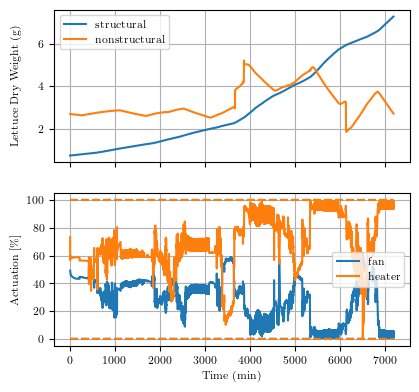

In [ ]:
# [donotremove]
fig, axs = plt.subplots(
    2, 1, sharex=True, figsize=set_size(width="ieee", subplots=(2, 1))
)
axs[0].plot(
    range(sim_steps),
    np.array(y_nexts).reshape(-1, 2)[:, -2],
    label="structural",
)
axs[0].plot(
    range(sim_steps),
    np.array(y_nexts).reshape(-1, 2)[:, -1],
    label="nonstructural",
)
axs[0].set_ylabel("Lettuce Dry Weight (g)")
axs[0].legend()
for i, (label, color) in enumerate(
    zip(
        [
            "fan",
            "heater",
        ],
        ["#1f77b4", "#ff7f0e"],
    )
):
    ax = axs[1]
    ax.plot(
        range(sim_steps),
        np.array(u0s).reshape(-1, 2)[:, i],
        color=color,
        label=label,
    )
    ax.plot(
        range(sim_steps),
        np.array(ums).reshape(-1, 4)[:, i],
        linestyle="--",
        color=color,
    )
    ax.plot(
        range(sim_steps),
        np.array(ums).reshape(-1, 4)[:, i + 2],
        linestyle="--",
        color=color,
    )

    ax.set_ylabel("Actuation [\\%]")
    ax.set_xlabel("Time (min)")
    ax.legend()

fig.align_ylabels()

fig.savefig("greenhouse_control.pdf")